In [1]:
import numpy as np
import torch
from graph_traffic.train_gnn import test_model, predict
import matplotlib.pyplot as plt
import pandas as pd
from graph_traffic.config import training_path
from graph_traffic.model_selection import get_node_ids
from graph_traffic.get_data import ubs_index
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.ticker import MaxNLocator

months = ["Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
ids_list = get_node_ids()
_, ubs_dict = ubs_index(ids_list)

df = pd.read_csv(f"{training_path}/gnn-results.csv", sep=";", usecols=["nombre", "evaluate_in", "seq_len", "epoch_selected", "config"])

C:\Users\Bened\PycharmProjects\madrid-traffic\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
maes = dict()
mses = dict()
for config in range(1, 6):
    print("config", config)
    maes[config] = dict()
    mses[config] = dict()
    for seq_len in [2, 4, 8, 16]:
        print("seq len", seq_len)
        maes[config][seq_len] = dict()
        mses[config][seq_len] = dict()
        for evaluate_in in months:
            print("evaluate month", evaluate_in, end="\r")
            maes[config][seq_len][evaluate_in] = dict()
            mses[config][seq_len][evaluate_in] = dict()
            for i in ids_list:
                maes[config][seq_len][evaluate_in][i] = []
                mses[config][seq_len][evaluate_in][i] = []
            row = df.loc[(df.evaluate_in==evaluate_in) & (df.seq_len==seq_len) & (df.config==config)].iloc[0]
            if np.isnan(row["epoch_selected"]):
                continue
            model_name = row["nombre"]
            epoch = int(row["epoch_selected"])
            model, test_loader, norm_layer, batch_size, graph = test_model(model_name, epoch=epoch)
            for x, y in test_loader:
                all = np.concatenate([x, y], axis=1)[..., 0]
                _, pred = predict(x, y, batch_size, graph, model, torch.device('cpu'), norm_layer)
                y = y[..., 0].detach().numpy()
                #y_modif = y_modif[:, :y.shape[0]*37, 0]
                pred = pred.detach().numpy()[:, :y.shape[0]*37, 0]
                pred = pred.reshape(-1, pred.shape[0], 37)
                for i in ids_list:
                    graph_id = ubs_dict[i]
                    pred_i = pred[:, :, graph_id]
                    y_i = y[:, :, graph_id]
                    maes[config][seq_len][evaluate_in][i].append(mean_absolute_error(pred_i, y_i))
                    mses[config][seq_len][evaluate_in][i].append(mean_squared_error(pred_i, y_i))

config 1
seq len 2
seq len 4month Dec
seq len 8month Dec
seq len 16onth Dec
config 2 month Dec
seq len 2
seq len 4month Dec
seq len 8month Dec
seq len 16onth Dec
config 3 month Dec
seq len 2
seq len 4month Dec
seq len 8month Dec
seq len 16onth Dec
config 4 month Dec
seq len 2
seq len 4month Dec
seq len 8month Dec
seq len 16onth Dec
config 5 month Dec
seq len 2
seq len 4month Dec
seq len 8month Dec
seq len 16onth Dec


In [3]:
def get_mean(l):
    if len(l) == 0:
        return np.nan
    else:
        return np.nanmean(l)

In [4]:
for config in range(1, 6):
    for seq_len in [2, 4, 8, 16]:
        maes_df = pd.DataFrame(maes[config][seq_len]).applymap(get_mean).sort_index()
        maes_df["avg"] = maes_df.loc[:, :"Dec"].mean(axis=1)
        maes_df["std"] = maes_df.loc[:, :"Dec"].std(axis=1)
        maes_df.round(4).to_csv(f"{training_path}/gnn/config{config}/maes_{seq_len}.csv")

In [5]:
for config in range(1, 6):
    for seq_len in [2, 4, 8, 16]:
        mses_df = pd.DataFrame(mses[config][seq_len]).applymap(get_mean).sort_index()
        mses_df["avg"] = mses_df.loc[:, :"Dec"].mean(axis=1)
        mses_df["std"] = mses_df.loc[:, :"Dec"].std(axis=1)
        mses_df.round(4).to_csv(f"{training_path}/gnn/config{config}/mses_{seq_len}.csv")

# Cualitativo

In [14]:
def get_plot(evaluate_in, seq_len, node_id, only_gnn=False):
    graph_id = ubs_dict[node_id]
    fig, axs = plt.subplots(3, 2, figsize=(20, 8))
    for config in [1, 2, 3, 4, 5]:
        row = df.loc[(df.evaluate_in==evaluate_in) & (df.seq_len==seq_len) & (df.config==config)].iloc[0]
        model_name = row["nombre"]
        epoch = int(row["epoch_selected"])
        model, test_loader, norm_layer, batch_size, graph = test_model(model_name, epoch=epoch)
        for x, y in test_loader:
            all = np.concatenate([x, y], axis=1)[..., 0]
            _, pred = predict(x, y, batch_size, graph, model, torch.device('cpu'), norm_layer)
            y = y[..., 0].detach().numpy()
            #y_modif = y_modif[:, :y.shape[0]*37, 0]
            pred = pred.detach().numpy()[:, :y.shape[0]*37, 0]
            pred = pred.reshape(-1, pred.shape[0], 37)
            break

        pred_i = pred[:, :, graph_id]
        pred_rep = [all[0, seq_len, graph_id]] * seq_len
        pred_rep_all = all[0, :seq_len, graph_id]
        drift_per_period = (all[0, seq_len, graph_id] - all[0, 0, graph_id]) / seq_len
        drift_pred = [all[0, seq_len, graph_id] + i*drift_per_period for i in range(1, seq_len+1)]
        all_i = all[:, :, graph_id]
        n_row = (config-1) // 2
        n_column = (config-1) % 2
        ax = axs[n_row, n_column]
        ax.plot(range(2*seq_len), all_i[0], "x-", alpha=0.2, color="black", label="Actual traffic")
        if only_gnn:
            label = "Forecast"
        else:
            label = f"gnn_config{config}"
        ax.plot(range(seq_len, 2*seq_len), pred_i[0], "x-", label=label)
        if not only_gnn:
            ax.plot(range(seq_len, 2*seq_len), pred_rep_all, "x-", label="repeat")
            ax.plot(range(seq_len, 2*seq_len), pred_rep, "x-", label="repeat_last")
            ax.plot(range(seq_len, 2*seq_len), drift_pred, "x-", label="drift")
        ax.set_title(f"Config. {config}")
        ax.set_xlabel("Periods of 15 minutes")
        #ax.set_xticks(range(2*seq_len))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_ylabel("Occupancy [%]")
        ax.legend()
    fig.tight_layout()
    axs[2, 1].axis("off")

In [15]:
def get_plot_sequential_for_config(config, evaluate_in, seq_len, n_nodes):
    row = df.loc[(df.evaluate_in==evaluate_in) & (df.seq_len==seq_len) & (df.config==config)].iloc[0]
    model_name = row["nombre"]
    max_epoch = int(row["epoch_selected"])
    fig, axs = plt.subplots(nrows=max_epoch+1, ncols=n_nodes, figsize=(8*n_nodes, (max_epoch+1)*2))

    #graph_id = ubs_dict[node_id]
    if max_epoch == 0:
        axs = [axs]
    _, test_loader, norm_layer, batch_size, graph = test_model(model_name, epoch=0)
    for x, y in test_loader:
        all_points = np.concatenate([x, y], axis=1)[..., 0]
        break
    for epoch in range(max_epoch+1):
        model, _, _, _, _ = test_model(model_name, epoch=epoch)
        #for x, y in test_loader:
        #    all = np.concatenate([x, y], axis=1)[..., 0]
        _, pred = predict(x, y, batch_size, graph, model, torch.device('cpu'), norm_layer)
        #y = y[..., 0].detach().numpy()
        #y_modif = y_modif[:, :y.shape[0]*37, 0]
        pred = pred.detach().numpy()[:, :y.shape[0]*37, 0]
        pred = pred.reshape(-1, pred.shape[0], 37)
        for i, node_id in enumerate(ids_list[:n_nodes]):
            graph_id = ubs_dict[node_id]
            pred_i = pred[:, :, graph_id]

            all_i = all_points[:, :, graph_id]
            #n_row = (config-1) // 2
            #n_column = (config-1) % 2
            ax = axs[epoch][i]
            ax.plot(range(2*seq_len), all_i[0], "x-", alpha=0.2, color="black", label="Actual traffic")
            label = "Forecast"

            ax.plot(range(seq_len, 2*seq_len), pred_i[0], "x-", label=label)

            ax.set_title(f"Epoch {epoch}")
            ax.set_xlabel("Periods of 15 minutes")
            #ax.set_xticks(range(2*seq_len))
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.set_ylabel("Occupancy [%]")
            ax.legend()

    fig.tight_layout()

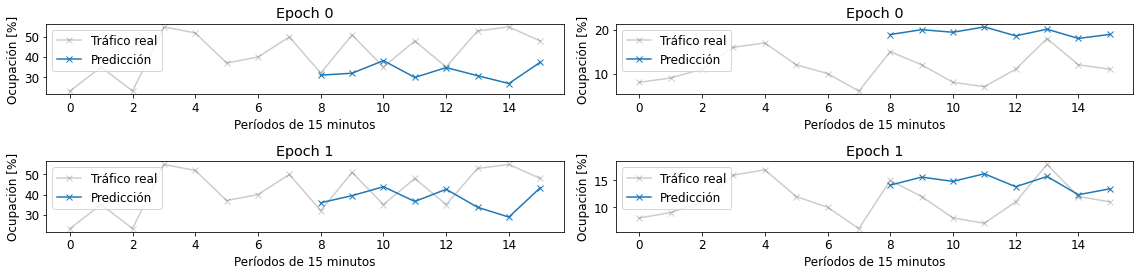

In [8]:
get_plot_sequential_for_config(1, "Jul", 8, 2)

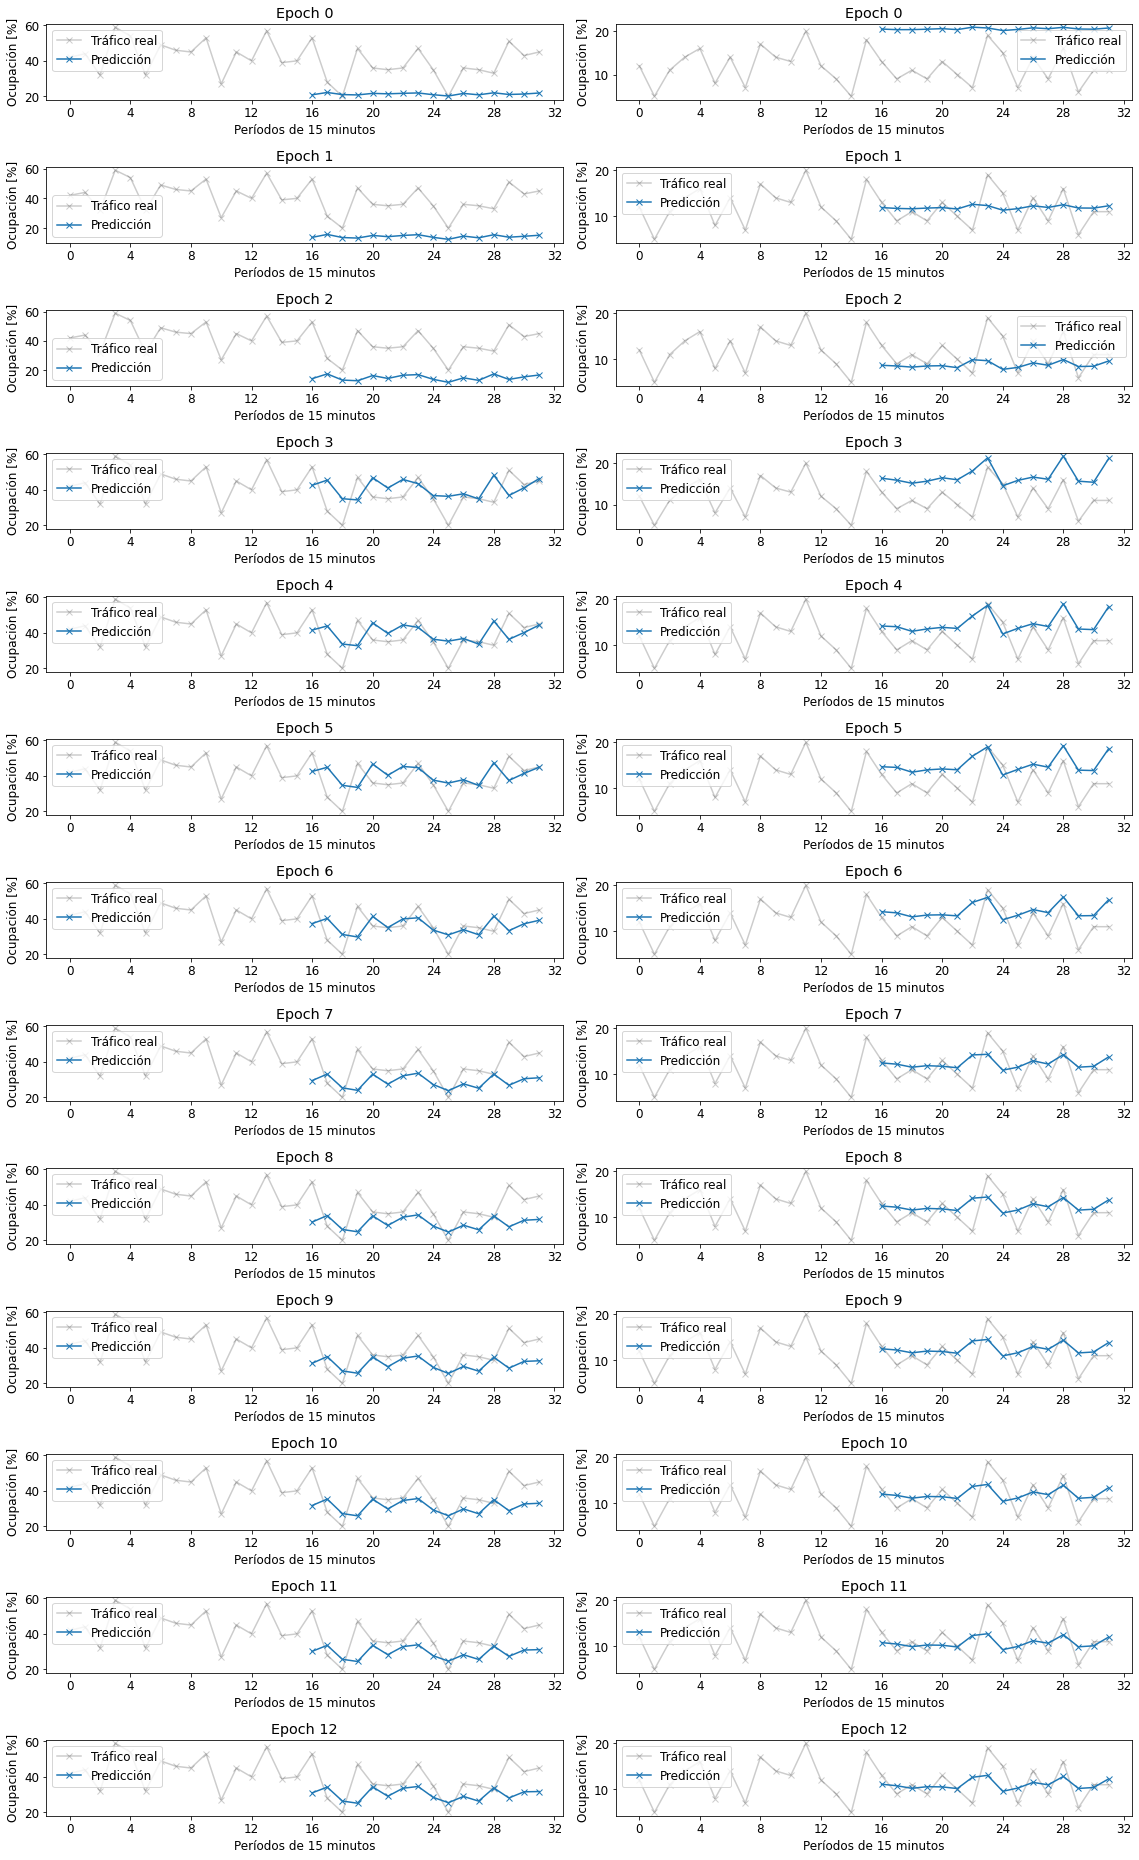

In [44]:
get_plot_sequential_for_config(config=3, evaluate_in="Jul", seq_len=16, n_nodes=2)

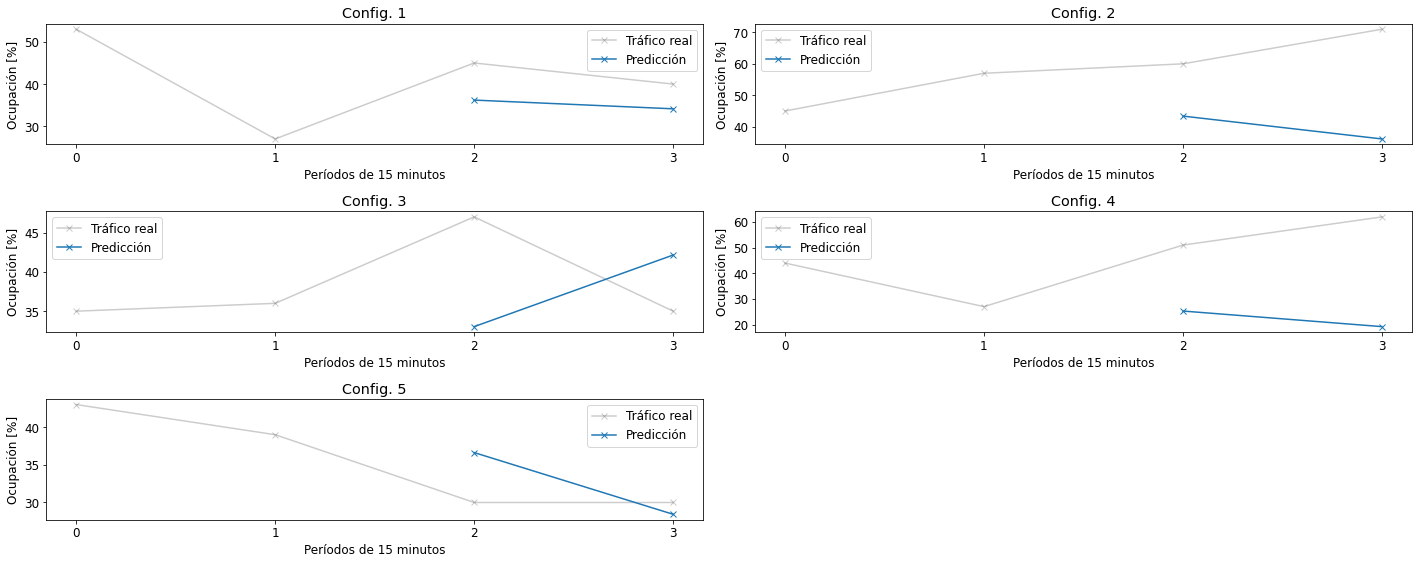

In [11]:
get_plot("Jul", 2, ids_list[0], only_gnn=True)

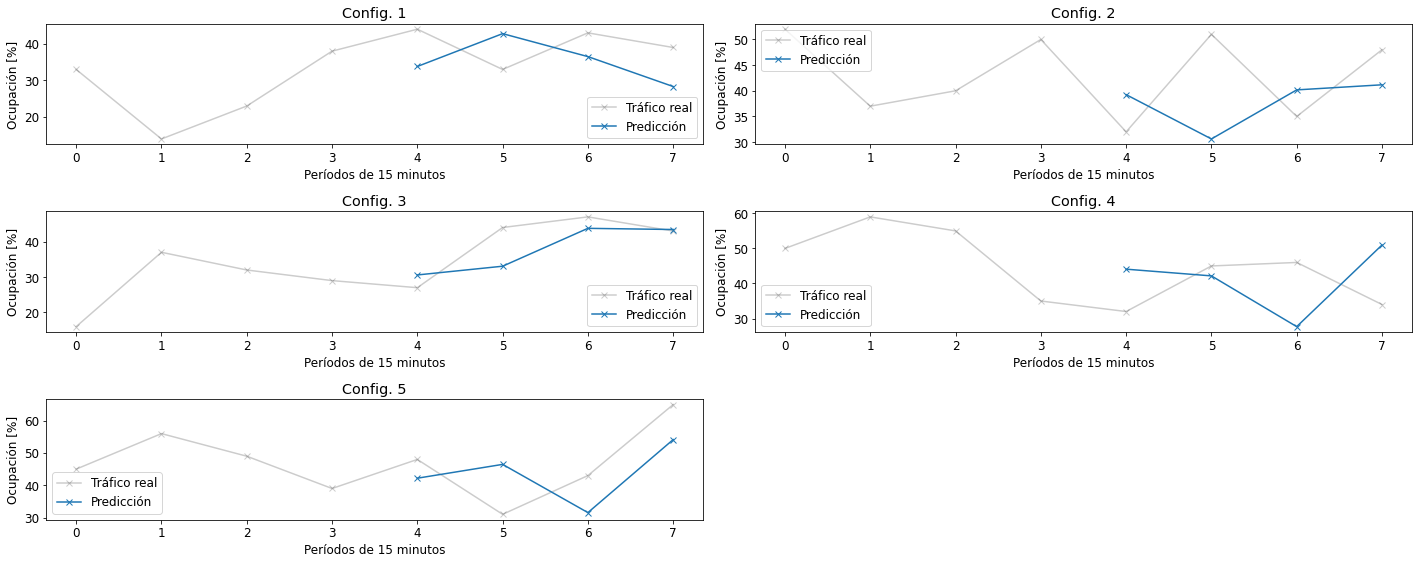

In [12]:
get_plot("Jul", 4, ids_list[0], only_gnn=True)

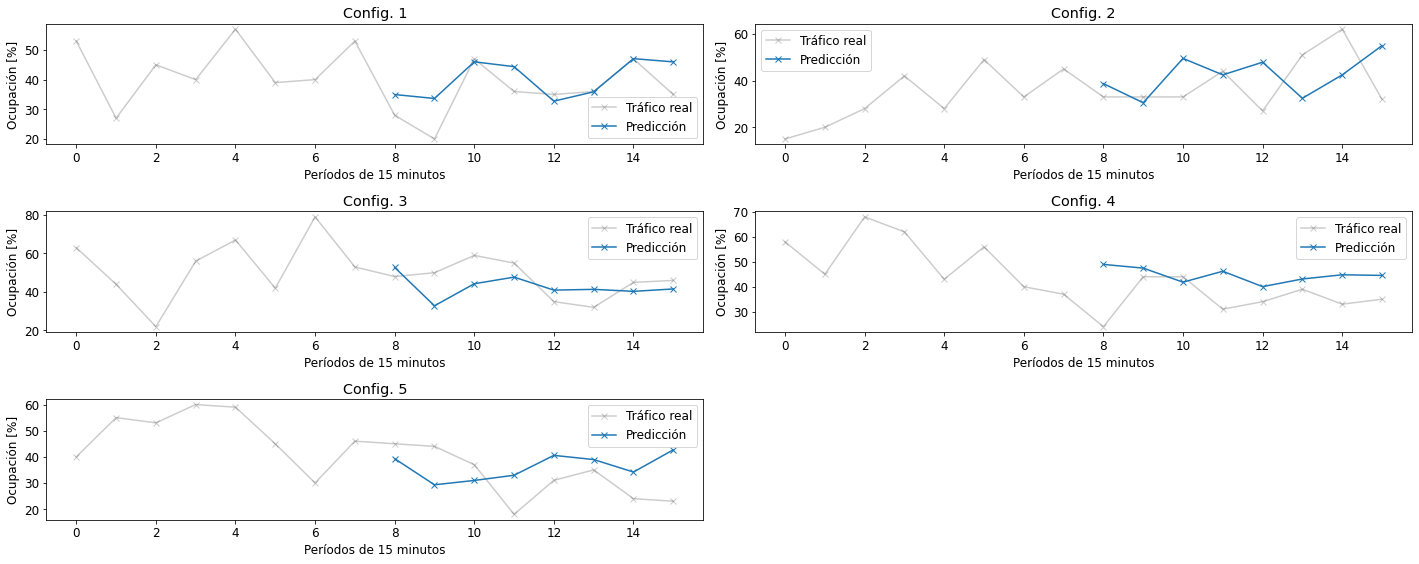

In [13]:
get_plot("Jul", 8, ids_list[0], only_gnn=True)

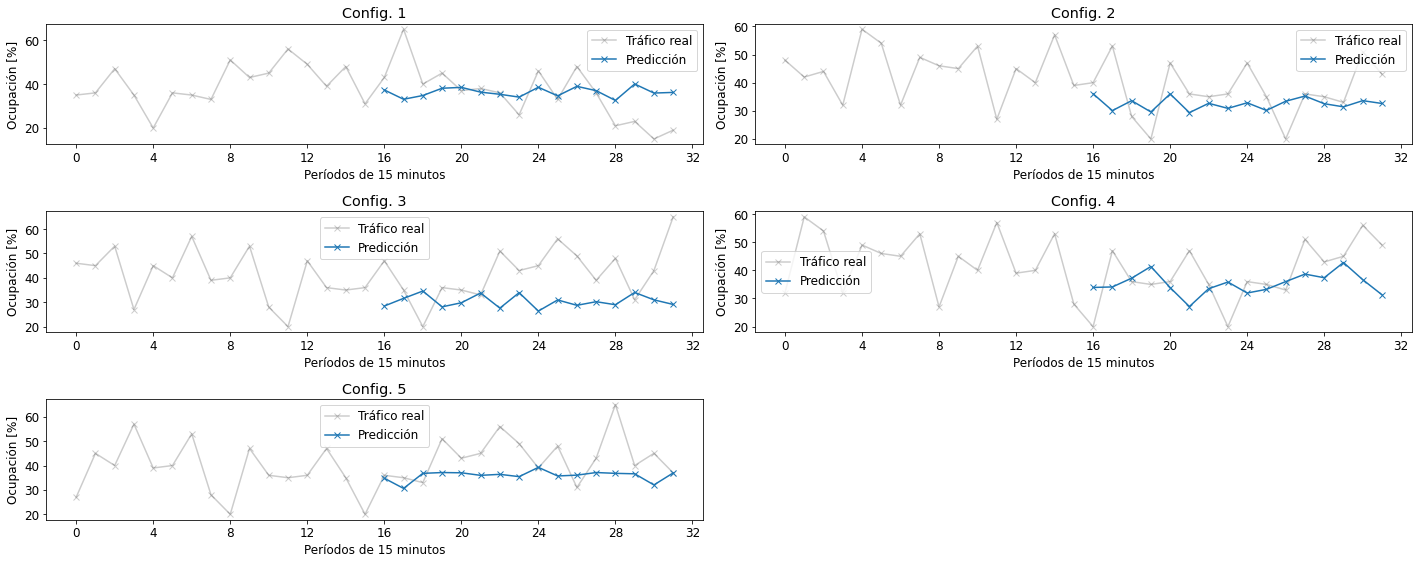

In [14]:
get_plot("Jul", 16, ids_list[0], only_gnn=True)

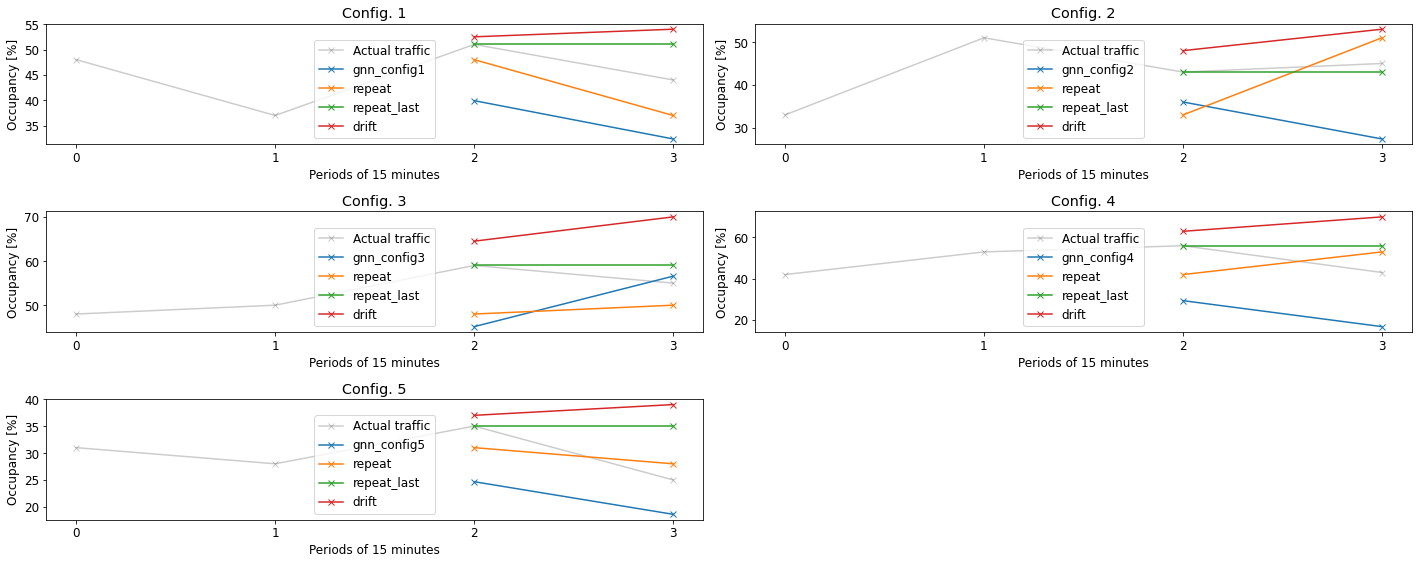

In [16]:
get_plot("Jul", 2, ids_list[0])

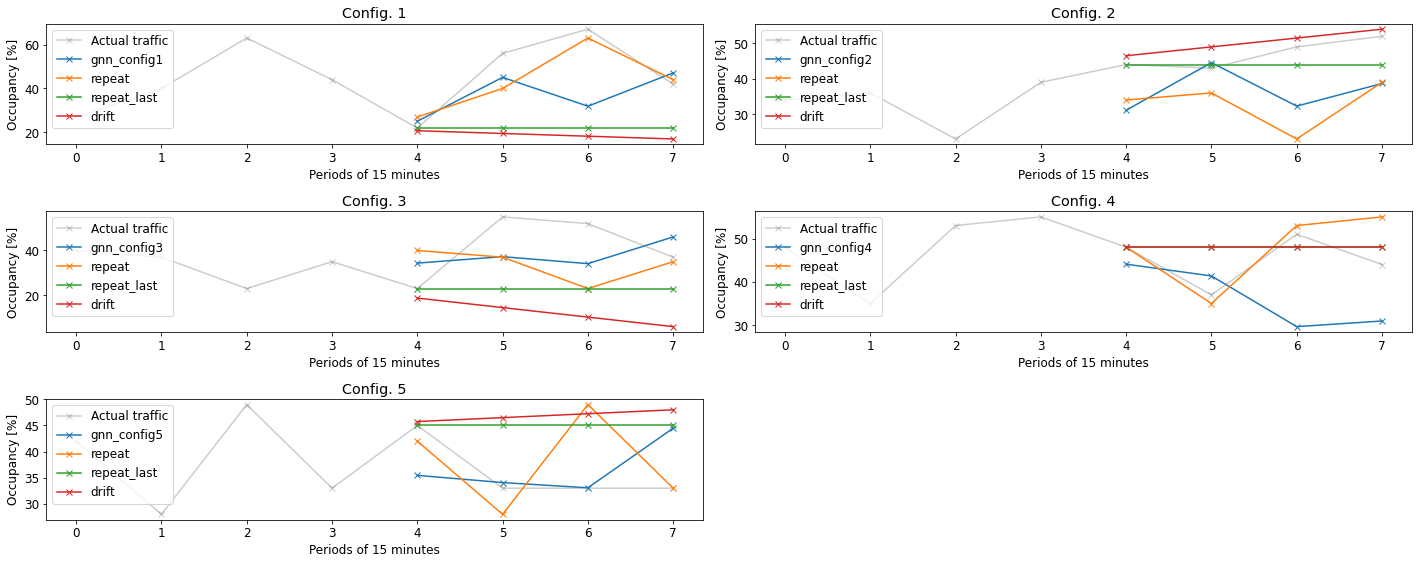

In [17]:
get_plot("Jul", 4, ids_list[0])

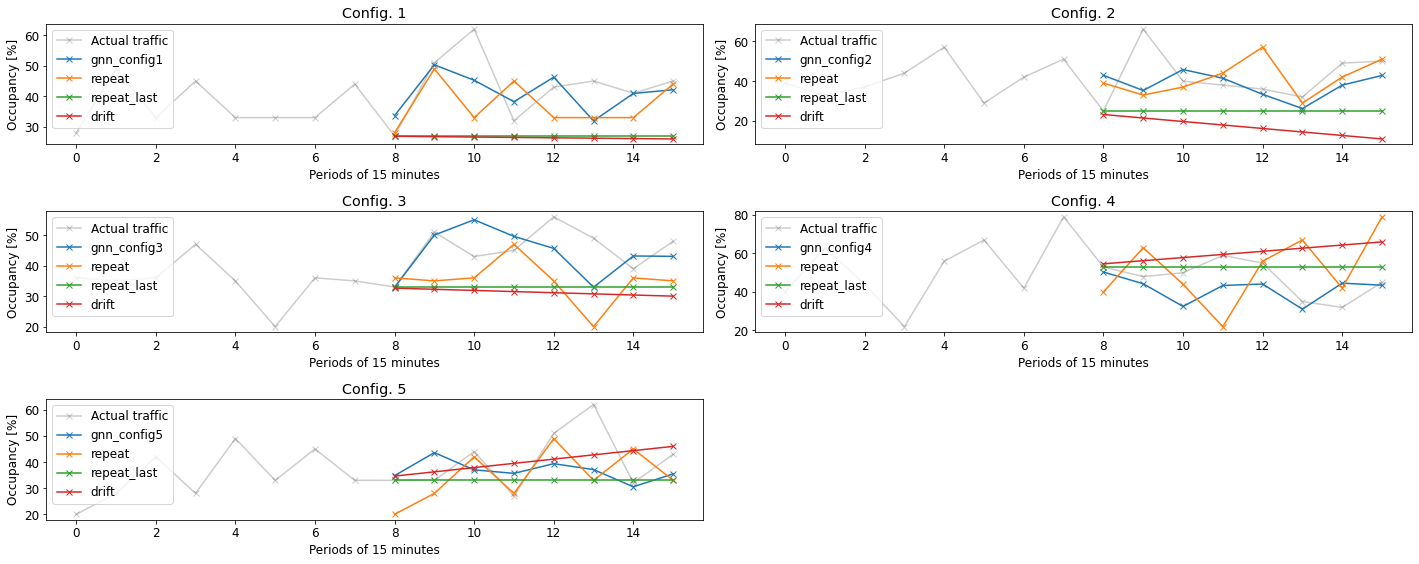

In [18]:
get_plot("Jul", 8, ids_list[0])

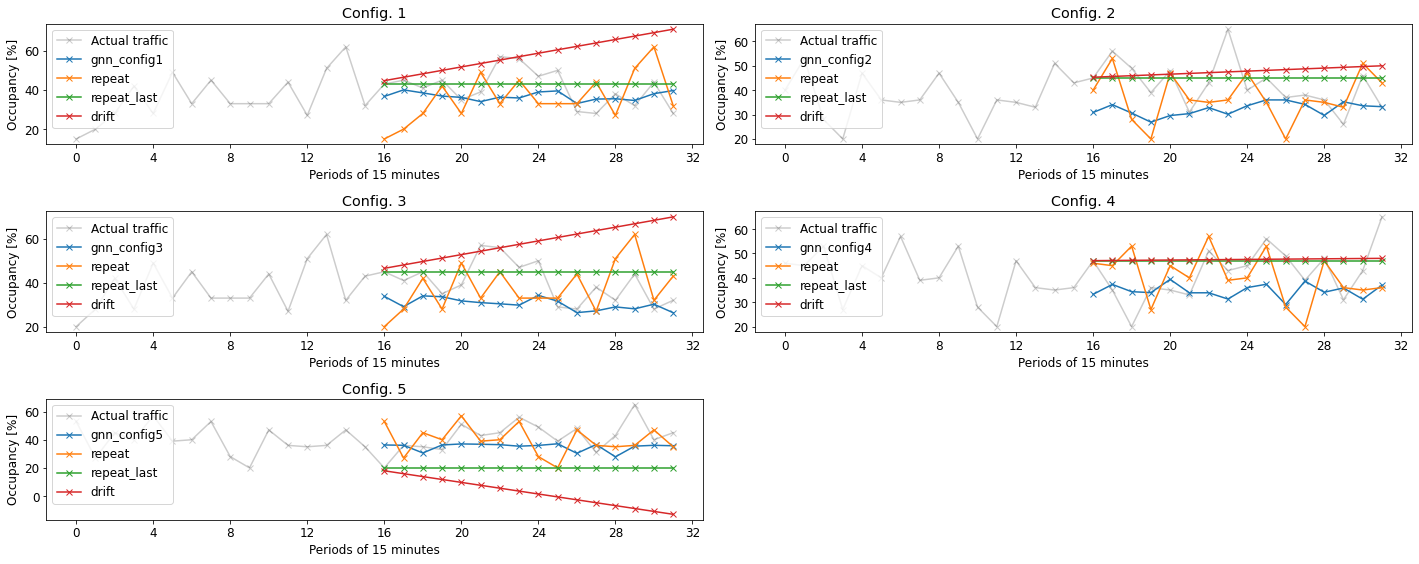

In [19]:
get_plot("Jul", 16, ids_list[0])

In [3]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from graph_traffic.config import training_path
configs = range(1, 6)
evaluate_in = "Jun"

df = pd.read_csv(f"{training_path}/gnn-results.csv", sep=";", usecols=["nombre", "evaluate_in", "seq_len", "epoch_selected", "config"])
df = df[df.evaluate_in == evaluate_in]
del df["evaluate_in"]
df.head()

,nombre,seq_len,epoch_selected,config
0,20220609_235507,2,0.0,1
1,20220610_004639,4,0.0,1
2,20220610_010454,8,1.0,1
3,20220610_014637,16,11.0,1
28,20220610_074714,2,4.0,2


In [8]:
df

,nombre,seq_len,epoch_selected,config
0,20220609_235507,2,0.0,1
1,20220610_004639,4,0.0,1
2,20220610_010454,8,1.0,1
3,20220610_014637,16,11.0,1
28,20220610_074714,2,4.0,2
29,20220610_080023,4,7.0,2
30,20220610_082106,8,9.0,2
31,20220610_084451,16,13.0,2
56,20220610_134230,2,4.0,3
57,20220610_135047,4,5.0,3


In [45]:
model, _, _, _, _ = test_model("20220609_235507", epoch=0)

In [56]:
i = 0
for p in model.named_parameters():
    i +=1
    print(p[0], len(p[1]), p[1])

encoder.layers.0.r_bias 64 Parameter containing:
tensor([0.6305, 0.9586, 0.5509, 0.4537, 0.3872, 0.6596, 0.7086, 1.0293, 0.7749,
        0.3201, 0.9533, 0.2793, 0.0374, 0.6564, 0.5503, 0.2080, 0.7916, 0.3352,
        0.8669, 0.5470, 0.9256, 0.8578, 0.4195, 0.8729, 0.7170, 1.0584, 0.6045,
        0.3321, 1.0686, 0.8383, 0.4980, 0.5390, 0.2638, 0.5959, 0.4611, 0.1872,
        1.0345, 0.4469, 0.8829, 0.1486, 0.1530, 0.1629, 0.1318, 0.4562, 0.3600,
        0.8698, 0.6917, 0.5723, 0.4165, 0.8119, 0.5698, 0.2989, 0.5665, 0.0251,
        0.6012, 1.0355, 0.2864, 0.8365, 0.7130, 0.4713, 0.4718, 0.0530, 0.4959,
        0.3929], requires_grad=True)
encoder.layers.0.u_bias 64 Parameter containing:
tensor([ 0.6302,  0.1415,  0.9167,  0.1708,  0.9336,  0.7486,  0.6522,  0.5503,
         1.0853,  0.0490,  0.7554,  0.4943,  0.5246,  0.1429,  0.5302,  0.3022,
         0.6257,  0.6046,  0.8249,  0.9057,  0.2080,  0.8464,  0.7530,  0.2725,
         0.5631,  0.8697,  0.9865,  0.4991,  0.5416, -0.1144,  0.

In [53]:
i

38

In [57]:
model.net

functools.partial(<class 'graph_traffic.dcrnn.DiffConv'>, k=2, in_graph_list=[Graph(num_nodes=2368, num_edges=27456,
      ndata_schemes={}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)}), Graph(num_nodes=2368, num_edges=60608,
      ndata_schemes={}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)})], out_graph_list=[Graph(num_nodes=2368, num_edges=27456,
      ndata_schemes={}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)}), Graph(num_nodes=2368, num_edges=60608,
      ndata_schemes={}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)})], dir='both')

In [58]:
model.net.project_fcs

AttributeError: 'functools.partial' object has no attribute 'project_fcs'